In [ ]:
import sys 
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns
from statannotations.Annotator import Annotator
from tqdm import tqdm

from src.utils import create_total_df

mpl.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"
sns.set(font_scale=0.8)

In [ ]:
def data_binning(df:pd.DataFrame,target_labels:list):
    thresh = np.arange(0,0.8,0.1)
    thresh = np.append(thresh,1.0)
    bin_dic = {}
    tick_names=[]
    violin_data_dic={label:[] for label in target_labels}
    for i in range(len(thresh)-1):
        upper_th = thresh[i+1]
        lower_th = thresh[i]
        tmp_df = df[(df['cos_sim']>lower_th)&(df['cos_sim']<upper_th)]
        for l in target_labels:
            violin_data_dic[l].append(tmp_df[l].values)
        tmp_dic = tmp_df.describe().loc['mean',target_labels]
        tmp_dic['count'] = tmp_df.describe().loc['count'].values[0]
        bin_dic[f"{lower_th:.1f}-{upper_th:.1f}"] = tmp_dic
        tick_names.append(f"{lower_th:.1f}-{upper_th:.1f}")
    tick_names.append('All')
    bin_dic['All'] = dict(df.describe().loc['mean',target_labels],count=len(df))
    bin_df = pd.DataFrame(bin_dic).T
    return (violin_data_dic,tick_names,bin_df)


def concat_df(tot_df:pd.DataFrame,ribo:pd.DataFrame,rna:pd.DataFrame):
    remover=lambda x:x.split('.')[0] # noqa E738
    ribo['ENST_ID']=ribo['transcript_id'].apply(remover)
    rna['ENST_ID']=rna['transcript_id'].apply(remover)
    df_concat=pd.merge(tot_df,ribo,on='ENST_ID',how='inner')
    df_concat=pd.merge(df_concat,rna,on='ENST_ID',how='inner')
    df_concat=df_concat[(df_concat['cds_len']!=0)&(df_concat['TPM_rna']!=0)]
    df_concat['TE'] = df_concat['TPM_ribo']/df_concat['TPM_rna']

    return df_concat

In [20]:
seq_df = pd.read_csv("../data/human/gencode44_utr_gene_unique_cdhit09.csv")
cl_dir = "../results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"
total_df_cl = create_total_df(cl_dir, seq_df)
total_df_cl = total_df_cl.drop("ENST_ID", axis=1).rename(
    columns={"ENST_ID_PRE": "ENST_ID"}
)

# 1. TE cell line

In [ ]:
## All cell line comprehensive process
#cell_lines = np.unique(seq_info['cell_line'])
seq_info = pd.read_table('../Biocontainer-pipeline/input/sample_info.txt')

cell_lines=['Brain', 'Breast', 'ES', 'Eye', 'HEK293',
            'Hela', 'HepG2','PC3', 'fibloblast']
target_labels=['TPM_rna','TPM_ribo','TE']
cell_df_dict={}

for cell in cell_lines:
    print(cell)
    ribo_srr = seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='ribo-seq')].srr_id.values[0]
    rna_srr =  seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='rna-seq')].srr_id.values[0]

    ribo = pd.read_csv(f'../Biocontainer-pipeline/output/{ribo_srr}/ReadCount_cds.csv',index_col=0).rename(columns={'TPM_cds':'TPM_ribo'})
    rna = pd.read_csv(f'../Biocontainer-pipeline/output/{rna_srr}/ReadCount_cds.csv',index_col=0).iloc[:,[0,-1]].rename(columns={'TPM_cds':'TPM_rna'})
    cell_df = concat_df(total_df_cl,ribo,rna)
    cell_df_dict[cell]=cell_df

Brain
Breast
ES
Eye
HEK293
Hela
HepG2
PC3
fibloblast


# 2. Cell line comparison

### top bin comparison

In [32]:
def boxplot_targets_topbin(
    df: pd.DataFrame,
    all_targets: list,
    violin_data_dic: dict,
    tick_names: list,
    save_name=None,
    values_name="values",
    tick_name="tick_name",
    target_name="target",
    figsize=(4,6)
):
    _, ax = plt.subplots(1, 1,figsize=figsize)

    plot_data_df = {values_name: [], tick_name: [], target_name: []}
    stats_pairs = []
    pvalues = []

    for target in all_targets:
        all_df = df[~((df["cos_sim"] > 0.7) & (df["cos_sim"] < 1))]
        ## only take highest bin amd all_data
        values = np.concatenate([violin_data_dic[target][-1], all_df[target].values])
        plot_data_df[values_name].extend(values)
        plot_data_df[tick_name].extend(
            np.concatenate(
                [
                    np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
                    np.repeat("All", len(all_df)),
                ]
            )
        )
        plot_data_df[target_name].extend(np.repeat(target, len(values)))

        ## stats info
        stats_pairs.append(((target, tick_names[-2]), (target, tick_names[-1])))
        stats_x = violin_data_dic[target][-1]
        stats_y = all_df[target].values
        pvalues.append(stats.mannwhitneyu(stats_x, stats_y)[-1])
    data_df = pd.DataFrame(plot_data_df)

    plot_params = {
        "data": data_df,
        "x": target_name,
        "y": values_name,
        "hue": tick_name,
        "showfliers": False,
    }
    sns.boxplot(**plot_params)

    annotator = Annotator(ax, stats_pairs, **plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    plt.setp(ax.get_xticklabels(), rotation=15)
    plt.tight_layout()
    plt.xlabel(None)

    if save_name:
        plt.savefig(f"./results/imgs/{save_name}")


def boxplot_targets_topbin_cell(cell_df_dict:dict,save_name=None,values_name='values',tick_name='tick_name',target_name='cell',target_label=['TE']):
    figsize = (6,4)
    _, ax = plt.subplots(1, 1, figsize=figsize)
    plot_data_df={values_name:[],tick_name:[],target_name:[]}
    stats_pairs = []
    pvalues = []
    for cell,cell_df in cell_df_dict.items():
        plot_cell_df={values_name:[],tick_name:[],target_name:[]}
        for target in target_label:
            all_df = cell_df[~((cell_df['cos_sim']>0.7)&(cell_df['cos_sim']<1))]
            violin_data_dic,tick_names,_=data_binning(cell_df,target_label)
            ## only take highest bin amd all_data
            values =np.concatenate([violin_data_dic[target][-1],all_df[target].values])
            plot_data_df[values_name].extend(values)
            plot_data_df[tick_name].extend(
                np.concatenate([np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
                np.repeat('All',len(all_df))]))
            plot_data_df[target_name].extend(np.repeat(cell,len(values)))

            plot_cell_df[values_name].extend(values)
            plot_cell_df[tick_name].extend(
                np.concatenate([np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
                np.repeat('All',len(all_df))]))
            ## stats info
            stats_pairs.append(((cell,tick_names[-2]),
                (cell,tick_names[-1])))
            stats_x = violin_data_dic[target][-1]
            stats_y = all_df[target].values

            pvalues.append(stats.mannwhitneyu(stats_x,stats_y)[-1])
    data_df = pd.DataFrame(plot_data_df)

    plot_params = {
        'data':data_df,
        'x':target_name,
        'y':values_name,
        'hue':tick_name,
        'showfliers':False,
    }
    sns.boxplot(**plot_params)

    annotator = Annotator(ax,stats_pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    # ax.set(ylabel=None)
    plt.setp(ax.get_xticklabels(), rotation=15)
    plt.xlabel(None)
    plt.tight_layout()

    if save_name:
        plt.savefig(f'../results/imgs/{save_name}')

In [14]:
diff_cells = ['Hela','PC3','Breast','HEK293','HepG2']
diff_cell_dict = {cell:cell_df_dict[cell] for cell in diff_cells}

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PC3_0.7-1.0 vs. PC3_All: Custom statistical test, P_val:3.210e-04
Hela_0.7-1.0 vs. Hela_All: Custom statistical test, P_val:3.387e-04
Breast_0.7-1.0 vs. Breast_All: Custom statistical test, P_val:2.086e-07
HEK293_0.7-1.0 vs. HEK293_All: Custom statistical test, P_val:4.978e-03
HepG2_0.7-1.0 vs. HepG2_All: Custom statistical test, P_val:3.566e-06


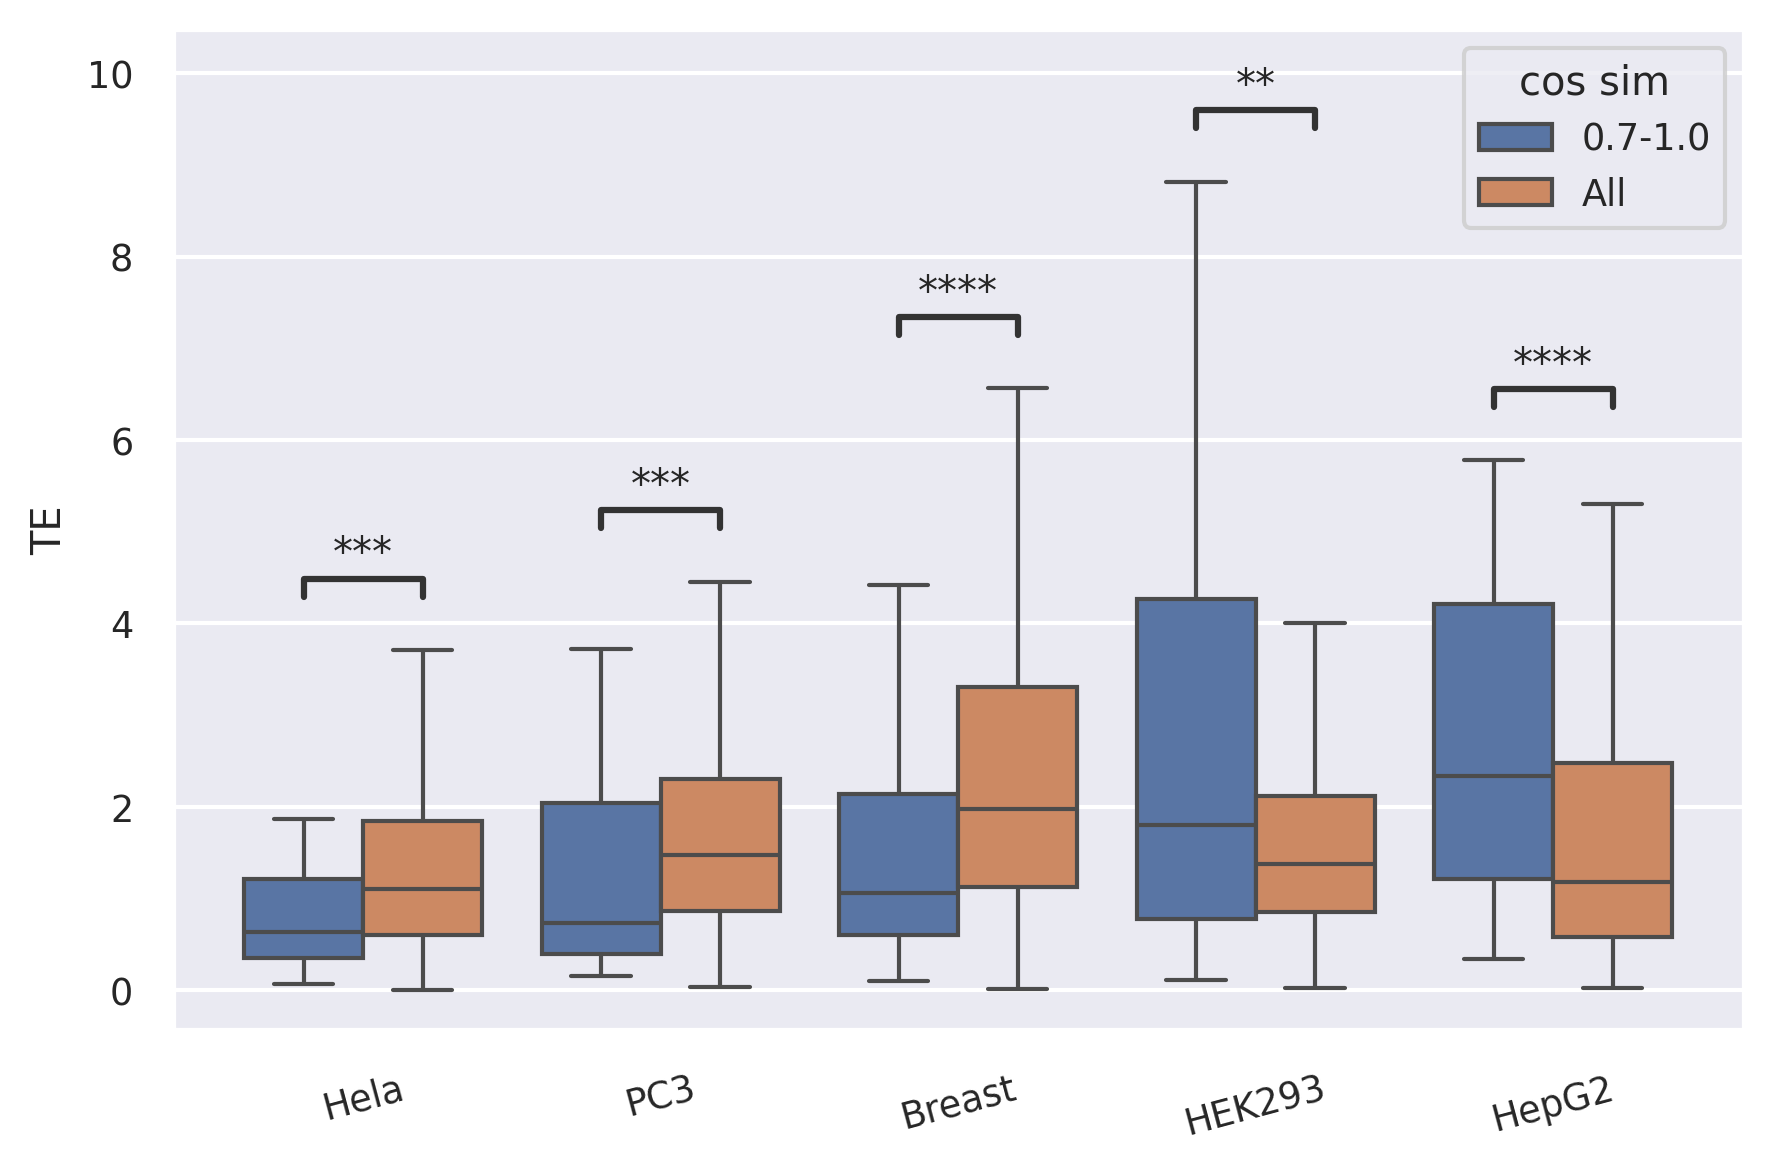

In [15]:
boxplot_targets_topbin_cell(diff_cell_dict,values_name='TE',tick_name='cos sim')